In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='whitegrid')

#### Estimating the model parameter
from sklearn.model_selection import validation_curve, GridSearchCV


from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline

#### One-K encoding
from sklearn.feature_extraction import DictVectorizer
#### Working with text data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#### Imputing missing data
from sklearn.experimental import enable_iterative_imputer # Нужно для активации IterativeImputer
from sklearn.impute import IterativeImputer, KNNImputer, MissingIndicator

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.datasets import  fetch_california_housing
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import k_means, KMeans
from sklearn.metrics import silhouette_score

In [70]:
df = sns.load_dataset('iris')

# Methods to estimate the model parameters (approximation)

#### Validation Curve

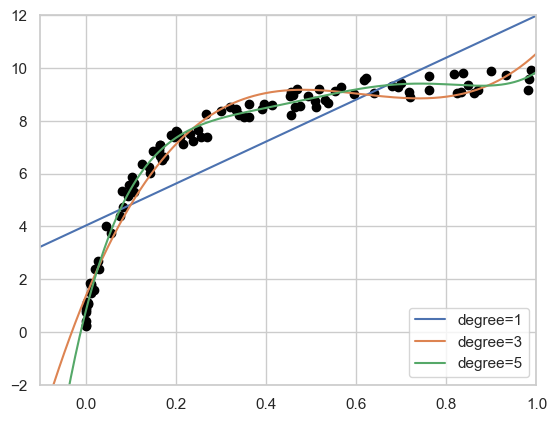

In [71]:
def polynomial_features(n_degree=2, **kwargs):
    return Pipeline(steps=[
        ('poly', PolynomialFeatures(n_degree, include_bias=True)),
        ('scaler', StandardScaler()),
         ('linreg', LinearRegression(**kwargs))]
                         )

def data_generation(N, error=1.0):
    rng = np.random.default_rng()
    X = (rng.random((N, 1)) ** 2)
    y = 10 - 1.0 / (X[:, 0] + 0.1)

    if error > 0:
        y += error * rng.random(N)
    return X, y

X, y = data_generation(100)

X_test = np.linspace(-0.1, 1.1, 500)[:, None]
plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()

for idx in range(1, 6, 2):
    y_test = polynomial_features(n_degree=idx).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label=f'degree={idx}')
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='lower right')

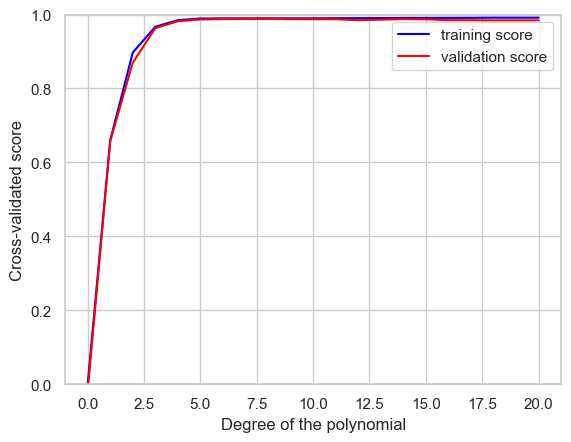

In [72]:
degree = np.arange(0, 21)
train_score, val_score = validation_curve(
    estimator=polynomial_features(),
    X=X,
    y=y,
    param_name="poly__degree",
    param_range=degree,
    cv=7
)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.xlabel('Degree of the polynomial')
plt.ylabel('Cross-validated score');

#### GridSearch

In [73]:
params_grid = {
    'poly__degree': np.arange(0, 21),
    'linreg__fit_intercept': [True, False]
}

grid = GridSearchCV(polynomial_features(), params_grid, cv=7)

grid.fit(X, y)

grid.best_params_

{'linreg__fit_intercept': True, 'poly__degree': np.int64(6)}

# Feature Engineering

#### One hot Encoding

In [74]:
data = [
 {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
 {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
 {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
 {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
 ]

vec = DictVectorizer(sparse=False, dtype=np.int64)
vec.fit_transform(data)
# help(DictVectorizer)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

In [75]:
vec.get_feature_names_out()

array(['neighborhood=Fremont', 'neighborhood=Queen Anne',
       'neighborhood=Wallingford', 'price', 'rooms'], dtype=object)

#### Text Features

In [76]:
sample = [
    'problem of evil',
    'evil queen',
    'horizon problem'
]

cvec = CountVectorizer()


X = cvec.fit_transform(sample)

pd.DataFrame(X.toarray(), columns=cvec.get_feature_names_out())


,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


In [77]:
vec

,"dtype dtype: dtype, default=np.float64The type of feature values. Passed to Numpy array/scipy.sparse matrixconstructors as the dtype argument.",<class 'numpy.int64'>
,"separator separator: str, default=""=""Separator string used when constructing new features for one-hotcoding.",'='
,"sparse sparse: bool, default=TrueWhether transform should produce scipy.sparse matrices.",False
,"sort sort: bool, default=TrueWhether ``feature_names_`` and ``vocabulary_`` should besorted when fitting.",True


In [78]:
vec = TfidfVectorizer()
X = vec.fit_transform(sample)

pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


#### Imputing NaN data

In [79]:
from numpy import nan

X = np.array([[ nan, 0, 3 ],
 [ 3, 7, 9 ],
 [ 3, 5, 2 ],
 [ 4, nan, 6 ],
 [ 8, 8, 1 ]])
y = np.array([14, 16, -1, 8, -5])

In [80]:
it_imp = IterativeImputer(random_state=42)

X_it = it_imp.fit_transform(X)

X

array([[nan,  0.,  3.],
       [ 3.,  7.,  9.],
       [ 3.,  5.,  2.],
       [ 4., nan,  6.],
       [ 8.,  8.,  1.]])

In [81]:
knn_imp = KNNImputer(n_neighbors=2)
X_knn = knn_imp.fit_transform(X)

print("После KNNImputer:\n", X_knn)

После KNNImputer:
 [[3.5 0.  3. ]
 [3.  7.  9. ]
 [3.  5.  2. ]
 [4.  6.  6. ]
 [8.  8.  1. ]]


In [82]:
# indicator = MissingIndicator()
# mask = indicator.fit_transform(X)
#
# # Создадим DataFrame для наглядности
# indicator_cols = [f"missing_{i}" for i in range(X.shape[1])]
# df_indicators = pd.DataFrame(mask, columns=indicator_cols)
#
# print("Матрица индикаторов:\n", df_indicators)

# Классификация

#### Наивный Байесовский Классификатор

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='whitegrid')
from sklearn.datasets import make_blobs, make_circles

Text(0.5, 1.0, 'Наивный Байесовкий Классификатор: make_blobs')

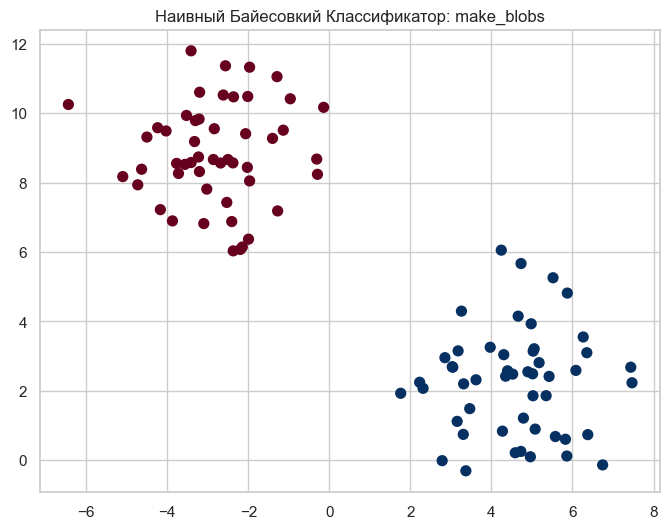

In [84]:
X, y = make_blobs(100, 2, centers=2, random_state=42, cluster_std=1.5)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
plt.title('Наивный Байесовкий Классификатор: make_blobs')

(np.float64(-7.13421392754893),
 np.float64(8.16455633640546),
 np.float64(-0.9036913809905549),
 np.float64(12.397293632864217))

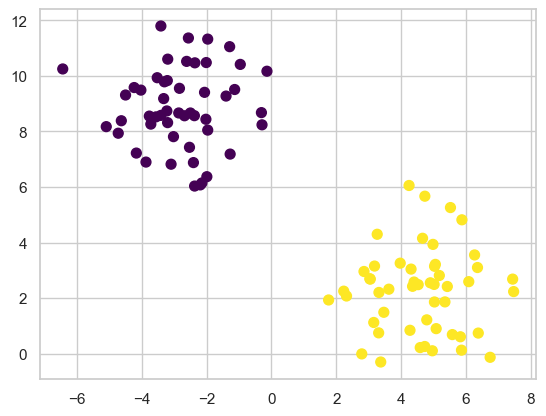

In [85]:
# importing the new model

model = GaussianNB()

model.fit(X, y)

rng = np.random.default_rng()
X_new = [-6, 14] + [14, 18]*rng.random(size=(2000, 2))
y_new = model.predict(X_new)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
lim = plt.axis()
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, s=20, cmap='viridis', alpha=0.1)
plt.axis(lim)

#### Полиномиальный Байесовский Классификатор

In [86]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    'alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware'
              ]

train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [87]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

model.fit(train.data, train.target)
labels = model.predict(test.data)

<Axes: >

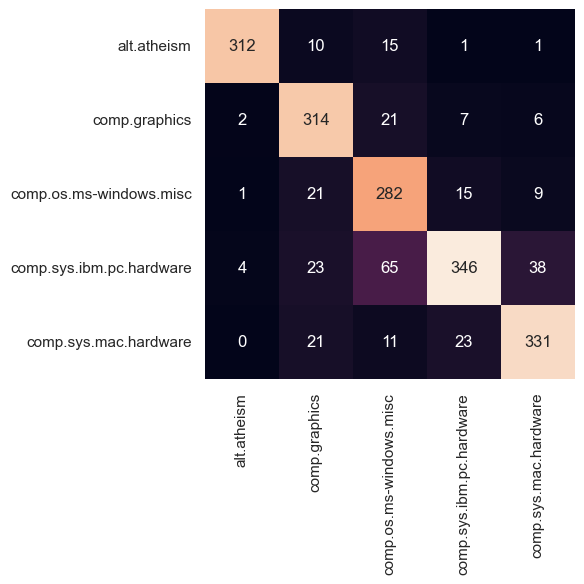

In [88]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=train.target_names, yticklabels=train.target_names)

#### Метод Опорных Векторов

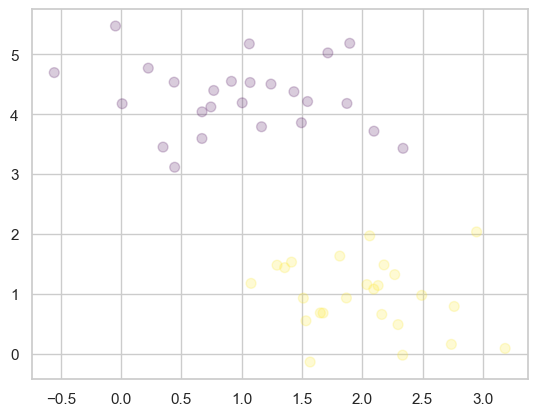

In [89]:
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.2, s=50, cmap='viridis')

(-1.0, 3.5)

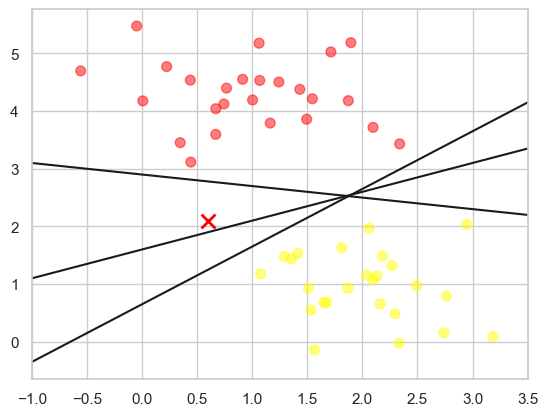

In [90]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, alpha=0.5, cmap='autumn')
plt.plot([0.6], [2.1], 'x',color='red', markersize=10, markeredgewidth=2)
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m*xfit + b, '-k')
plt.xlim(-1, 3.5)

(-1.0, 3.5)

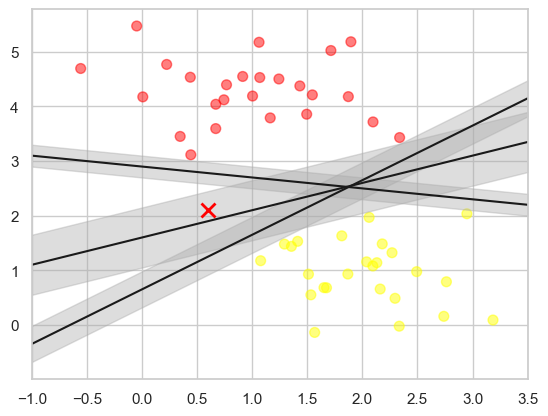

In [91]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, alpha=0.5, cmap='autumn')
plt.plot([0.6], [2.1], 'x',color='red', markersize=10, markeredgewidth=2)
for m, b, d in[(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)

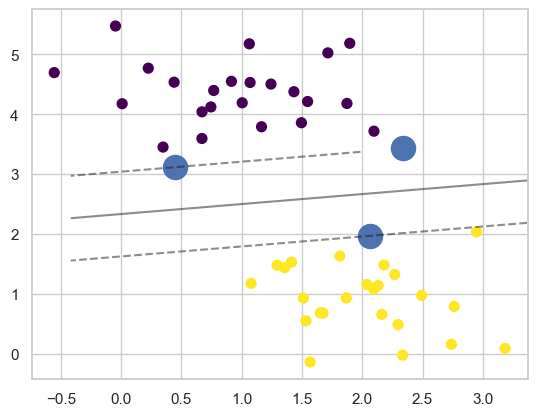

In [92]:
model = SVC(kernel='linear', C=1e10)
model.fit(X, y)

def plot_svc_decision_function(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)

    X, Y = np.meshgrid(y, x)

    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=300, lw=1, facecolors=None)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
plot_svc_decision_function(model)

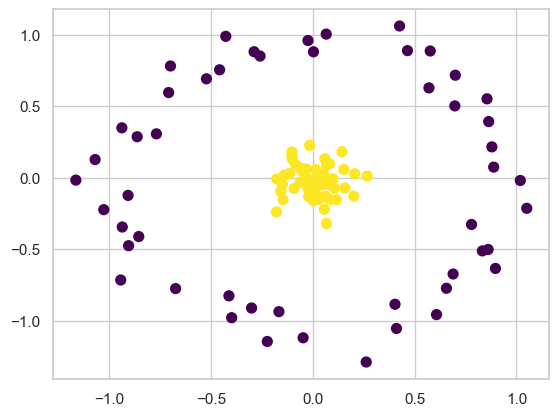

In [93]:
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear', C=1e10).fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
plot_svc_decision_function(model, plot_support=False)

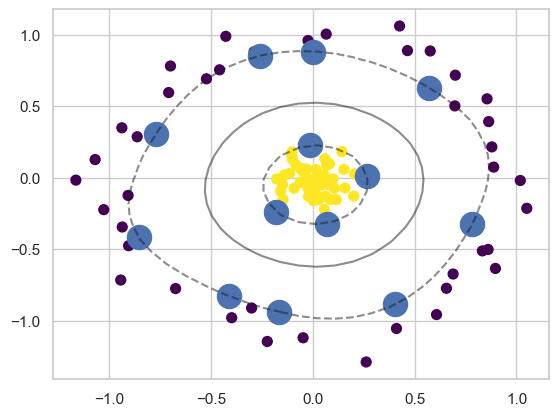

In [94]:
clf = SVC(kernel='rbf', C=1e10)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
plot_svc_decision_function(clf)

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=300, lw=1, facecolors='none')

#### Случайные Леса

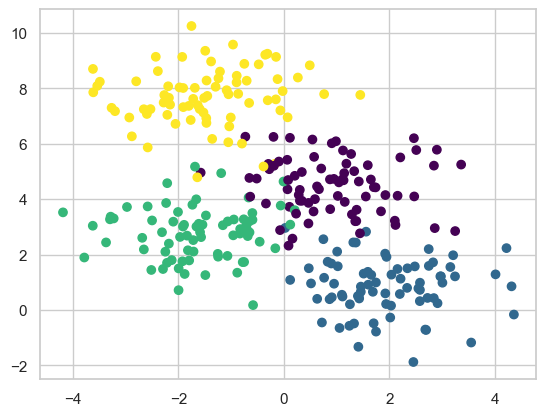

In [95]:
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')

In [96]:
# model = DecisionTreeClassifier().fit(X, y)

def viz_tree_classifier(model, X, y, ax=None, cmap='viridis'):
    ax = ax or plt.gca()

    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    model.fit(X, y)

    xx, yy = np.meshgrid(np.linspace(*xlim, num= 200), np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.linspace(0, n_classes - 1.5, n_classes), cmap=cmap)
    ax.set(xlim=xlim, ylim = ylim)


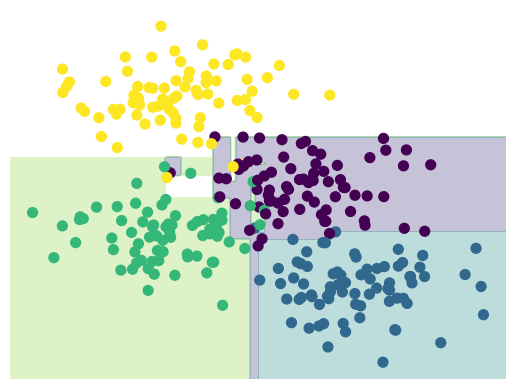

In [97]:
viz_tree_classifier(DecisionTreeClassifier(), X, y)

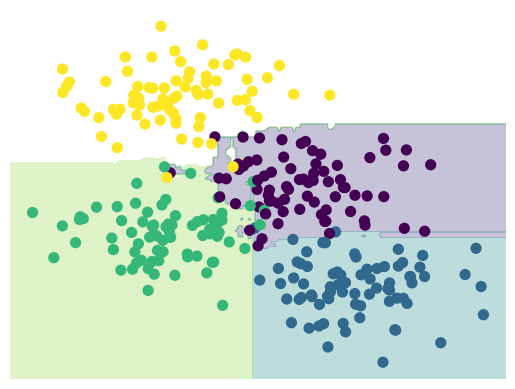

In [98]:
viz_tree_classifier(RandomForestClassifier(n_estimators=100, random_state=0), X, y)

# Регрессия

#### Линейная Регрессия

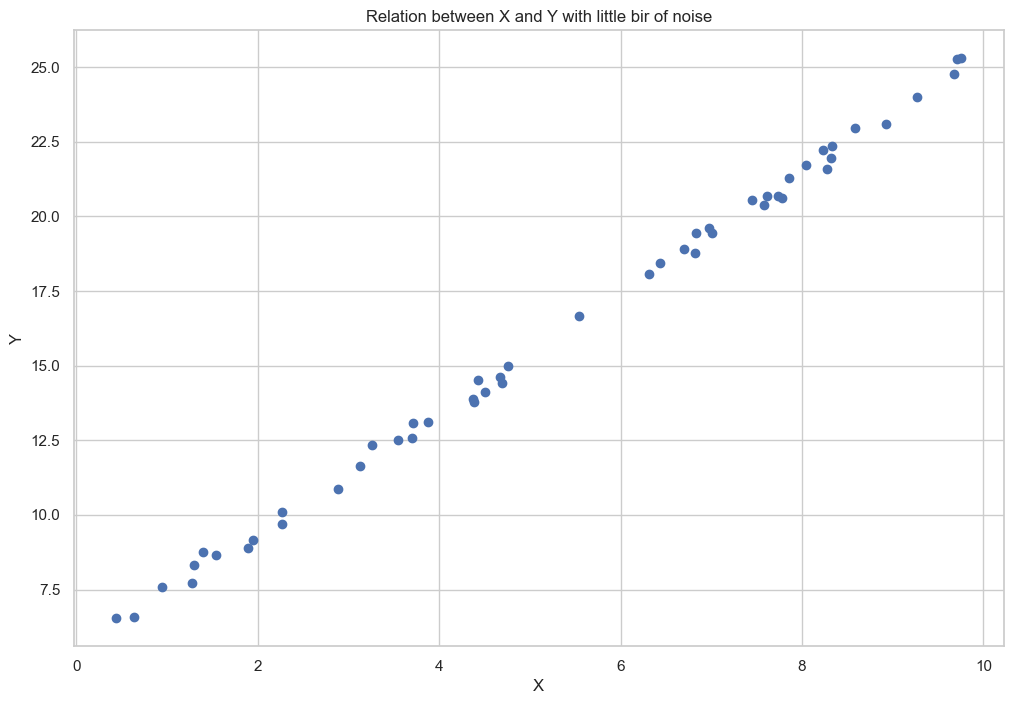

In [99]:
rng = np.random.default_rng(42)

x = 10*rng.random(size=50)
y = 2*x + 5+ rng.random(size=50)

plt.figure(figsize=(12, 8))
plt.scatter(x, y)
plt.title('Relation between X and Y with little bir of noise')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Text(0, 0.5, 'Y_train ')

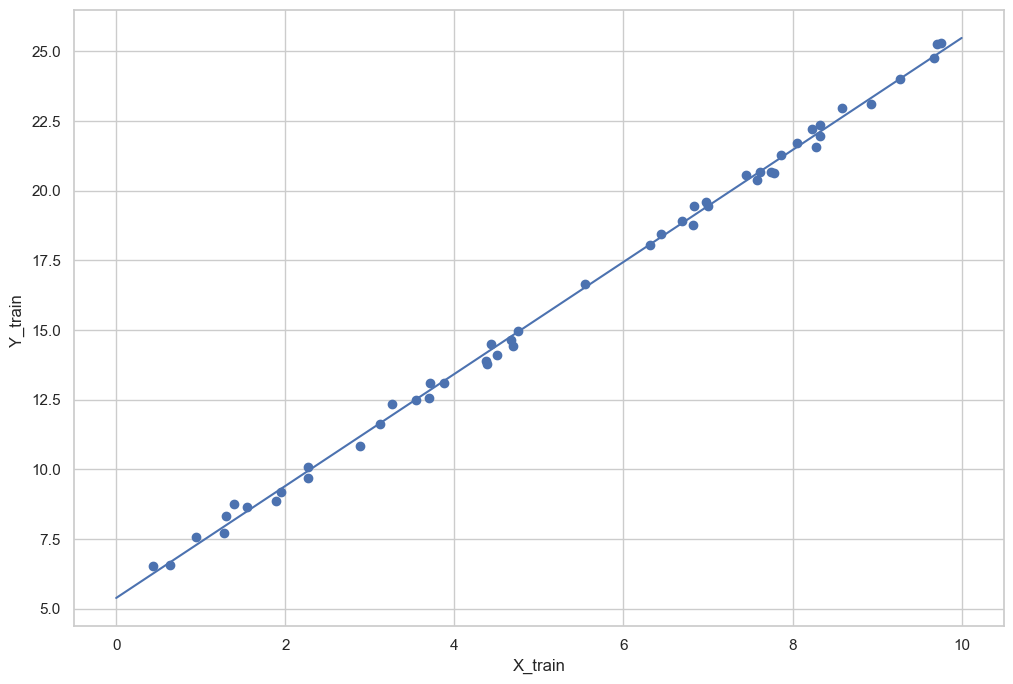

In [100]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.figure(figsize=(12, 8))
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlabel('X_train')
plt.ylabel('Y_train ')

In [101]:
%echo Model slope: {model.coef_[0]}
%echo Model intercept: {model.intercept_}

Model slope: 2.009260294679879
Model intercept: 5.388640055111885


In [102]:
x = np.array([1, 2, 3])

poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 1.,  1.,  1.],
       [ 2.,  4.,  8.],
       [ 3.,  9., 27.]])

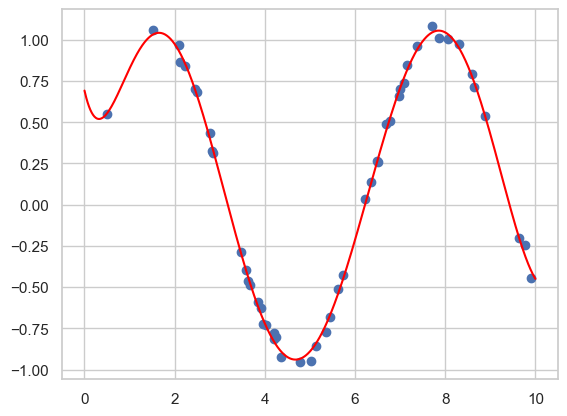

In [103]:
poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())

rng = np.random.default_rng()

x = 10 * rng.random(50)
y = np.sin(x) + 0.1 * rng.random(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit, color='red')

#### Метод Опорных Векторов

In [104]:
# houses_california = fetch_california_housing()
#
# target = np.array(houses_california['target'])[:, np.newaxis]
# data = np.array(houses_california['data'])
#
# # houses_california = pd.DataFrame(np.concatenate([data, target], axis=1))
# x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.8, random_state=42)
#
# model = make_pipeline(StandardScaler(), SVR(kernel='linear'))
#
# params_grid = {'svr__C': [1., 5., 10., 50.],
#                'svr__gamma': [0.0001, 0.0005,0.001, 0.005]}
#
# grid = GridSearchCV(model, params_grid)
#
# %timeit grid.fit(x_train, y_train.ravel())
# print(f'Grid Params: {grid.best_params_}')

In [105]:
# model = grid.best_estimator_
#
# y_pred = model.predict(x_test)

#### Случайные Леса

<ErrorbarContainer object of 3 artists>

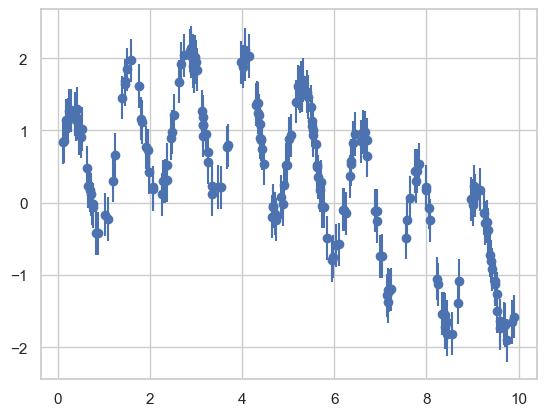

In [106]:
rng = np.random.default_rng()

x = 10 * rng.random(size=200)

def model(x, sigma=0.3):
    fast_osc = np.sin(5 * x)
    slow_osc = np.sin(0.5*x)

    noise = sigma*rng.random(size=len(x))

    return fast_osc + slow_osc + noise


y = model(x)

plt.errorbar(x, y, 0.3, fmt='o')

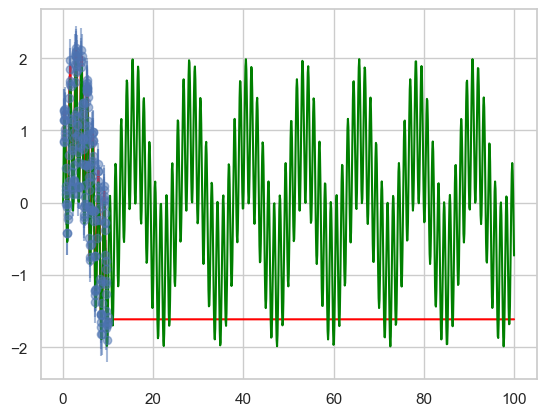

In [107]:
regressor_forest= RandomForestRegressor(n_estimators=200)

regressor_forest.fit(x[:, np.newaxis], y)

x_fit = np.linspace(0, 100, 1000)
y_fit = regressor_forest.predict(x_fit[:, np.newaxis])
y_true = model(x_fit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(x_fit, y_fit, color='red')
plt.plot(x_fit, y_true, color='green')
plt.show()

# Кластеризация

#### k-Means

Text(0, 0.5, 'Y')

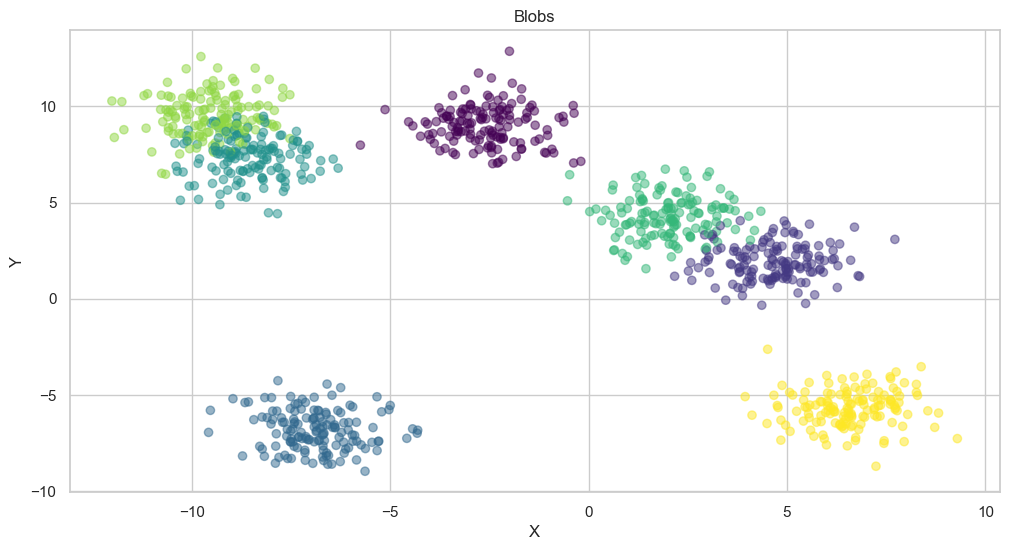

In [108]:
X, y = make_blobs(n_samples=1000, centers=7, random_state=42)

plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, cmap='viridis')
plt.title('Blobs')
plt.xlabel('X')
plt.ylabel('Y')

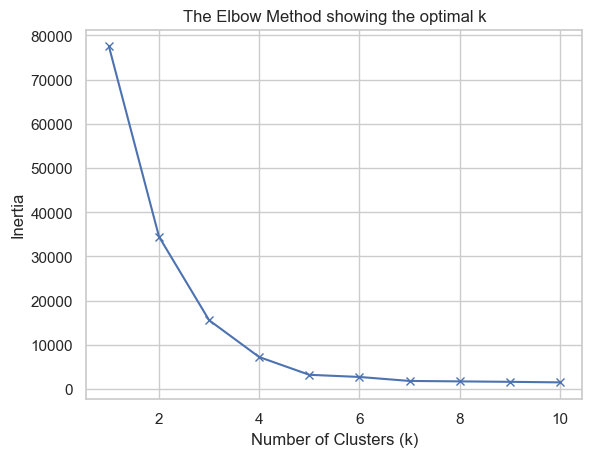

In [109]:
inertia = []
K = range(1, 11)

for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeanModel.fit(X)
    inertia.append(kmeanModel.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [110]:
kmeans = KMeans(n_clusters=7, n_init='auto')
labels = kmeans.fit_predict(X)

# Получаем средний коэффициент для всей модели
score = silhouette_score(X, labels)
print(f"Средний силуэт: {score:.3f}")

Средний силуэт: 0.637


#### gmm

# Понижение Размерности

Использование метода PCA для понижения размерности включает обнуление одной или нескольких из наименьших главных компонент, в результате чего данные
проецируются на пространство меньшей размерности с сохранением максимальной
дисперсии данных.

In [111]:
A = rng.random(size=(2, 2))       # linear transform
Z = rng.random(size=(200, 2))     # 200 samples, 2 features

X = Z @ A                          # shape: (200, 2)

pca = PCA(n_components=2)
pca.fit(X)

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",2
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'auto'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized SVD 

In [112]:
pca = PCA(n_components=1)

pca.fit(X)
X_pca = pca.transform(X)

print(f'Original shape: {X.shape}')
print(f'Transformed shape: {X_pca.shape}')

Original shape: (200, 2)
Transformed shape: (200, 1)


(np.float64(-0.024270313716314808),
 np.float64(1.265877809731432),
 np.float64(0.0008754622617519192),
 np.float64(1.322142913224129))

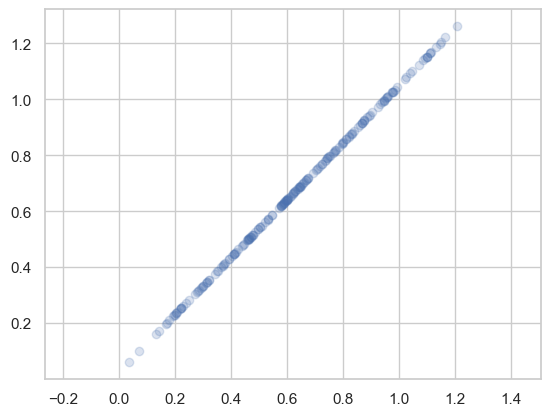

In [113]:
# Inverse Transform

X_new = pca.inverse_transform(X_pca)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.2)
plt.axis('equal')

Более светлые точки — исходные данные, а более темные — спроецированная
версия